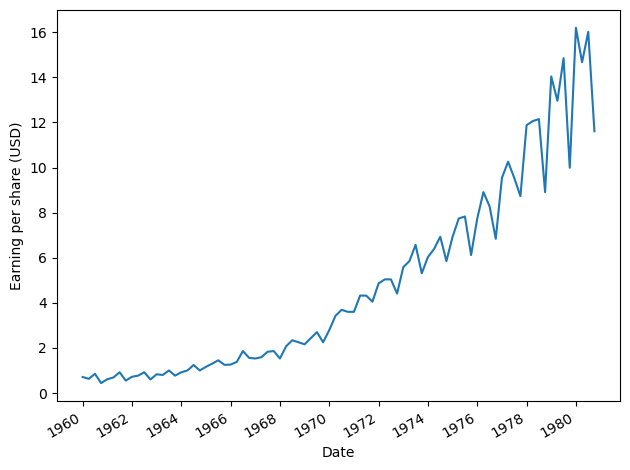

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('./jj.csv')

fig, ax = plt.subplots()

ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earning per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

In [2]:
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(df['data'])

print(ad_fuller_result[0])
print(ad_fuller_result[1])

2.742016573457468
1.0


In [3]:
#1차 차분
eps_diff = np.diff(df['data'], n=1)

ad_fuller_result = adfuller(eps_diff)

print(ad_fuller_result[0])
print(ad_fuller_result[1])

-0.407409763638043
0.9088542416911309


In [4]:
#2차 차분
eps_diff2 = np.diff(eps_diff, n=1)

ad_fuller_result = adfuller(eps_diff2)

print(ad_fuller_result[0])
print(ad_fuller_result[1])

-3.5851628747931517
0.006051099869603741


In [5]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #오름차순 정렬
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [6]:
from itertools import product

ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 2

order_list = list(product(ps, qs))

In [7]:
train = df.data[:-4]

result_df = optimize_ARIMA(train, order_list, d)
result_df

/tmp/ipykernel_7149/2571977672.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list): #(p, q) 조합 생성


  0%|          | 0/16 [00:00<?, ?it/s]

/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/seongwoo/anaco

,"(p,q)",AIC
0,"(3, 3)",115.273665
1,"(3, 1)",115.624980
2,"(3, 2)",115.672008
3,"(3, 0)",154.430678
4,"(0, 3)",194.654716
5,"(0, 2)",209.274543
6,"(2, 3)",220.666885
7,"(1, 3)",228.267839
8,"(1, 2)",228.935907
9,"(2, 2)",229.974675


/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


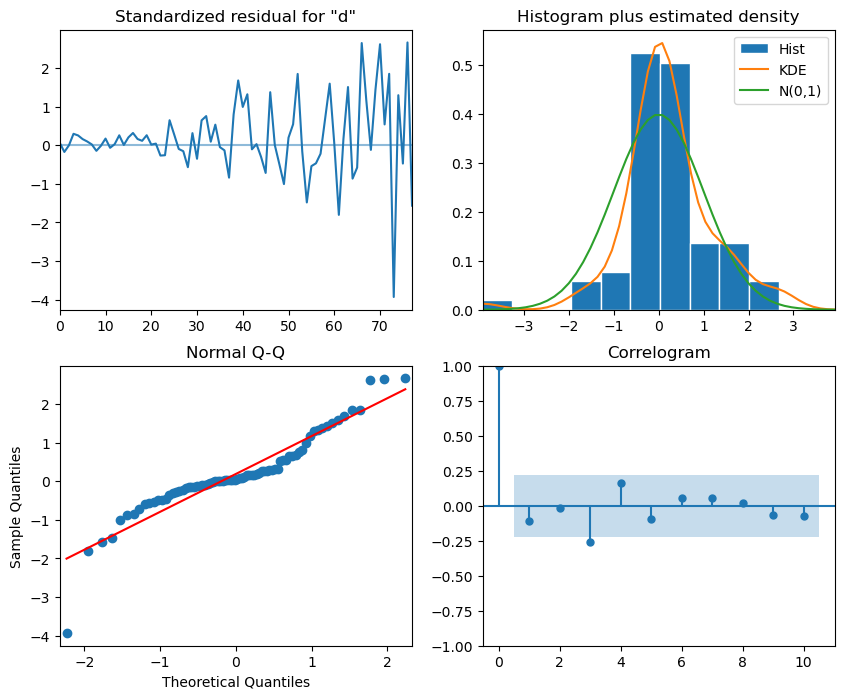

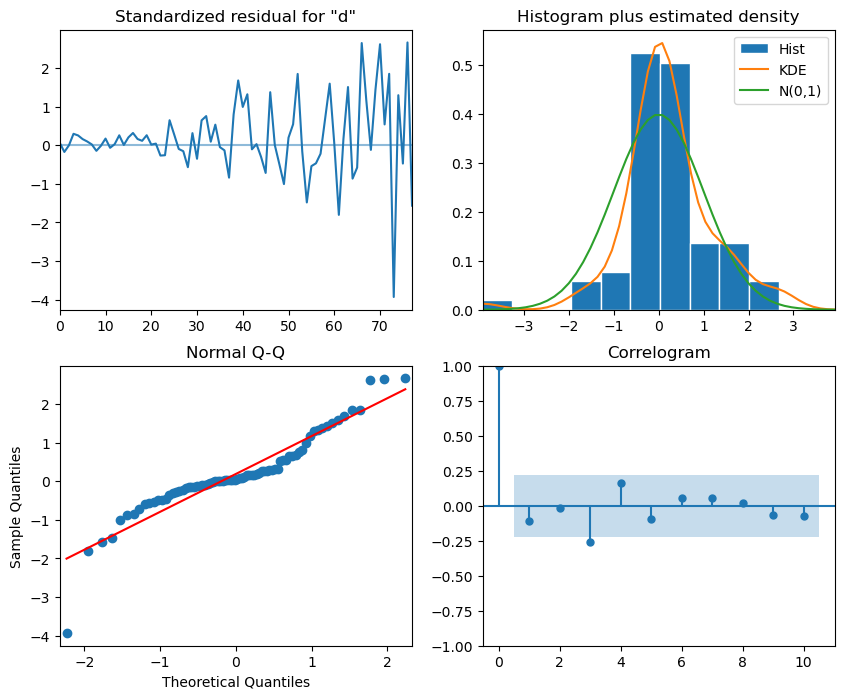

In [8]:
model = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit = model.fit(disp=False)

model_fit.plot_diagnostics(figsize=(10,8))

In [21]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = model_fit.resid # 모델의 잔차를 변수에 저장

k = acorr_ljungbox(residuals, np.arange(1, 11, 1)) # 처음 10개의 지연에 대해 융-박스 테스트 적용

print(k)

      lb_stat  lb_pvalue
1    1.583947   0.208193
2    1.585094   0.452690
3    7.242882   0.064546
4    9.166799   0.057063
5    9.780272   0.081706
6   10.009054   0.124271
7   10.258275   0.174404
8   10.294646   0.244952
9   10.636937   0.301418
10  11.097156   0.349999


In [36]:
test = df.iloc[-4:]
test['naive_seasonal'] = df['data'].iloc[76:80].values # 베이스라인 모델

/tmp/ipykernel_7149/4135603806.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['naive_seasonal'] = df['data'].iloc[76:80].values # 베이스라인 모델


In [37]:
test

,date,data,naive_seasonal
80,1980-01-01,16.20,14.04
81,1980-04-01,14.67,12.96
82,1980-07-02,16.02,14.85
83,1980-10-01,11.61,9.99


In [38]:
ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean #1980년에 대한 예측값을 가져온다

test['ARIMA_pred'] = ARIMA_pred

/tmp/ipykernel_7149/627147677.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_pred'] = ARIMA_pred


In [39]:
test.head()

,date,data,naive_seasonal,ARIMA_pred
80,1980-01-01,16.20,14.04,15.858615
81,1980-04-01,14.67,12.96,14.380478
82,1980-07-02,16.02,14.85,16.371732
83,1980-10-01,11.61,9.99,11.683178


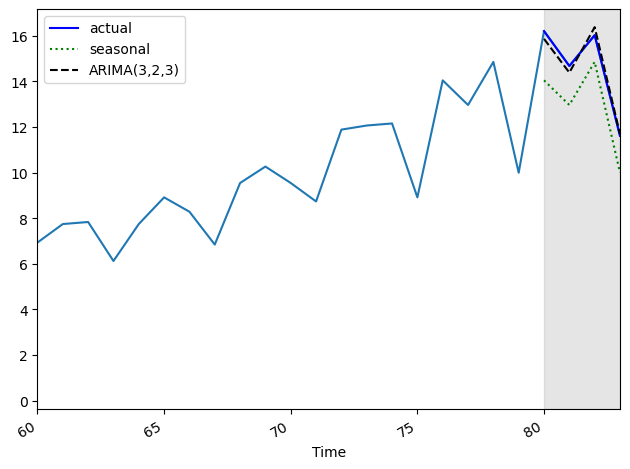

In [43]:
fig, ax = plt.subplots()

ax.plot(df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'g:', label='seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)')
ax.legend(loc=2)
ax.set_xlabel('Time')

ax.axvspan(80, 83, color='#808080', alpha=0.2)

ax.set_xlim(60, 83)


fig.autofmt_xdate()
plt.tight_layout()

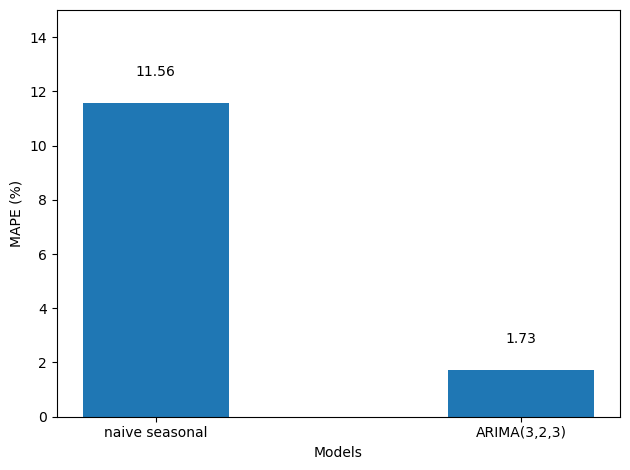

In [44]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])

fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(3,2,3)']
y = [mape_naive_seasonal, mape_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value, 2)), ha='center')

plt.tight_layout()